In [55]:
import glob
import netCDF4 as nc
import pandas as pd
import numpy as np
import xarray as xr
import xesmf as xe
import cartopy.crs as ccrs
import os

In [56]:
lat_bnds, lon_bnds = [25, 50], [-125, -70]
lat_lst = np.arange(lat_bnds[0], lat_bnds[1]+0.01, 0.5)
lon_lst = np.arange(lon_bnds[0], lon_bnds[1]+0.01, 0.5)
print(lat_lst[1]-lat_lst[0], lon_lst[1]-lon_lst[0])
print(len(lat_lst), len(lon_lst))
projection_dimension = [129, 135]

0.5 0.5
51 111


# CRU .nc file

In [16]:
## CRU: 1981 - 1990 Not available

files_list = glob.glob(rf"/home/uditbhatia/Documents/Sarth/CRU/cru_ts3.23.*.pre.dat.nc")
# files_list
ds = xr.open_mfdataset(files_list,combine = 'by_coords')
print(ds.dims)
print(ds.coords)
print()
ds = ds.sel(time=((ds.time.dt.year >= 1948) & (ds.time.dt.year <= 2005)))
print(ds.dims)
print(ds.coords)
print()
ds = ds.sel(lat=slice(*lat_bnds), lon=slice(*lon_bnds))
print(ds.dims)
print(ds.coords)
print()
ds.to_netcdf(rf"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/03_Preprocess_Data/NC_Files/CRU.nc")
print("****************************************************************************")
print()

Frozen({'lon': 720, 'lat': 360, 'time': 840})
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1941-01-16 1941-02-15 ... 2010-12-16

Frozen({'lon': 720, 'lat': 360, 'time': 696})
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1948-01-16 1948-02-15 ... 2005-12-16

Frozen({'lon': 110, 'lat': 50, 'time': 696})
Coordinates:
  * lon      (lon) float64 -124.8 -124.2 -123.8 -123.2 ... -71.25 -70.75 -70.25
  * lat      (lat) float64 25.25 25.75 26.25 26.75 ... 48.25 48.75 49.25 49.75
  * time     (time) datetime64[ns] 1948-01-16 1948-02-15 ... 2005-12-16

****************************************************************************



# CRU .npy Regridded

In [24]:
ds = xr.open_dataset(r"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/03_Preprocess_Data/NC_Files/CRU.nc")
dr = ds["pre"]
ds_out = xr.Dataset(
    {
        "lat": (["lat"], lat_lst),
        "lon": (["lon"], lon_lst),
    }
)
regridder = xe.Regridder(ds, ds_out, "bilinear")
dr_out = regridder(dr)
dr_out = dr_out.fillna(0)
dr_np = dr_out.to_numpy()
np.save(
    r"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/03_Preprocess_Data/npy_Files/CRU.npy", 
    dr_np
    )

# CMIP5 data

In [ ]:
for model in ['GFDL-CM3', 'MIROC-ESM', 'CanESM2']:
    files_list = glob.glob(rf"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/02_Raw_Data/CMIP5 Data/mon/pr_Amon_{model}_historical_r1i1p1_*.nc")
    print(f"{model}: {len(files_list)}")
    ds = xr.open_mfdataset(files_list,combine = 'by_coords')
    print(ds.dims)
    print(ds.coords)
    print()
    ds = ds.sel(time=((ds.time.dt.year >= 1948) & (ds.time.dt.year <= 2005)))
    print(ds.dims)
    print(ds.coords)
    print()
    ds = ds.sel(lat=slice(*lat_bnds), lon=slice(*[x%360 for x in lon_bnds]))
    print(ds.dims)
    print(ds.coords)
    print()
    ds.to_netcdf(rf"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/03_Preprocess_Data/NC_Files/{model}_mon.nc")
    print("****************************************************************************")
    print()

In [33]:
for model in ['GFDL-CM3', 'MIROC-ESM', 'CanESM2']:
    ds = xr.open_dataset(rf"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/03_Preprocess_Data/NC_Files/{model}_mon.nc")
    dr = ds["pr"]
    ds_out = xr.Dataset(
        {
            "lat": (["lat"], lat_lst),
            "lon": (["lon"], [x%360 for x in lon_lst]),
        }
    )
    regridder = xe.Regridder(ds, ds_out, "bilinear")
    dr_out = regridder(dr)
    dr_np = dr_out.to_numpy()
    np.save(
        rf"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/03_Preprocess_Data/npy_Files/{model}_mon.npy", 
        dr_np
        )

In [29]:
model = 'HadGEM2-ES'
files_list = glob.glob(rf"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/02_Raw_Data/CMIP5 Data/pr_day_{model}_historical_r1i1p1_*.nc")
print(f"{model}: {len(files_list)}")
ds = xr.open_mfdataset(files_list,combine = 'by_coords')
print(ds.dims)
print(ds.coords)
print()
ds = ds.sel(time=((ds.time.dt.year >= 1948) & (ds.time.dt.year <= 2005)))
ds = ds.resample(time = '1MS').mean()
print(ds.dims)
print(ds.coords)
print()
ds = ds.sel(lat=slice(*lat_bnds), lon=slice(*[x%360 for x in lon_bnds]))
print(ds.dims)
print(ds.coords)
print()
ds.to_netcdf(rf"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/03_Preprocess_Data/NC_Files/{model}_mon.nc")
print("****************************************************************************")
print()

HadGEM2-ES: 11
Frozen({'time': 38160, 'bnds': 2, 'lat': 145, 'lon': 192})
Coordinates:
  * time     (time) object 1899-12-01 12:00:00 ... 2005-11-30 12:00:00
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1

Frozen({'time': 695, 'lat': 145, 'bnds': 2, 'lon': 192})
Coordinates:
  * time     (time) object 1948-01-01 00:00:00 ... 2005-11-01 00:00:00
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1

Frozen({'time': 695, 'lat': 21, 'bnds': 2, 'lon': 29})
Coordinates:
  * time     (time) object 1948-01-01 00:00:00 ... 2005-11-01 00:00:00
  * lat      (lat) float64 25.0 26.25 27.5 28.75 30.0 ... 46.25 47.5 48.75 50.0
  * lon      (lon) float64 236.2 238.1 240.0 241.9 ... 283.1 285.0 286.9 288.8

****************************************************************************



In [34]:
model = 'HadGEM2-ES'
ds = xr.open_dataset(rf"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/03_Preprocess_Data/NC_Files/{model}_mon.nc")
dr = ds["pr"]
ds_out = xr.Dataset(
    {
        "lat": (["lat"], lat_lst),
        "lon": (["lon"], [x%360 for x in lon_lst]),
    }
)
regridder = xe.Regridder(ds, ds_out, "bilinear")
dr_out = regridder(dr)
dr_np = dr_out.to_numpy()
np.save(
    rf"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/03_Preprocess_Data/npy_Files/{model}_mon.npy", 
    dr_np
    )
# X = np.load(r"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/03_Preprocess_Data/npy_Files/HadGEM2-ES_mon.npy")
# Y = np.empty((696,51,111))
# Y[:-1,:,:] = np.array(X)
# Y[-1,:,:] = np.array(X[-1,:,:])
# np.save(
#     rf"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/03_Preprocess_Data/npy_Files/HadGEM2-ES_mon.npy", 
#     Y
#     )

# Reanalysis Data

In [46]:
def process(var_name):
    filename = rf"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/02_Raw_Data/NCEP_NCAR_Reanalysis1/{var_name}_combined.nc"
    ds = xr.open_dataset(filename)
    ds = ds.sel(time=((ds.time.dt.year >= 1948) & (ds.time.dt.year <= 2005)))
    ds = ds.resample(time = '1MS').mean()
    dr = ds[var_name]

    ds_out = xr.Dataset(
        {
            "lat": (["lat"], lat_lst),
            "lon": (["lon"], [x%360 for x in lon_lst]),
        }
    )
    regridder = xe.Regridder(ds, ds_out, "bilinear")
    dr_out = regridder(dr)
    dr_np = dr_out.to_numpy()
    np.save(
        rf"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/03_Preprocess_Data/npy_Files/{var_name}_mon.npy", 
        dr_np
        )

In [47]:
for var in ['omega','pres','rhum','uwnd','vwnd']:
    process(var)
    print(var)

omega
pres
rhum
uwnd
vwnd


# Elevation Data

In [57]:
ds = xr.open_dataset(r"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/02_Raw_Data/SRTM/elevation_US.nc")
ds

<xarray.Dataset>
Dimensions:  (lat: 2485, lon: 5483)
Coordinates:
  * lat      (lat) float64 24.53 24.54 24.55 24.56 ... 49.35 49.36 49.37 49.38
  * lon      (lon) float64 -124.8 -124.7 -124.7 -124.7 ... -69.95 -69.94 -69.93
Data variables:
    Band1    (lat, lon) float32 ...
    crs      |S1 ...
Attributes:
    Conventions:  CF-1.5
    GDAL:         GDAL 3.4.0, released 2021/11/04
    history:      Tue Jun 07 12:15:21 2022: GDAL Create( C:\Users\sarth\Downl...

In [58]:
dr = ds['Band1']
dr

<xarray.DataArray 'Band1' (lat: 2485, lon: 5483)>
[13625255 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 24.53 24.54 24.55 24.56 ... 49.35 49.36 49.37 49.38
  * lon      (lon) float64 -124.8 -124.7 -124.7 -124.7 ... -69.95 -69.94 -69.93
Attributes:
    long_name:     GDAL Band Number 1
    grid_mapping:  crs

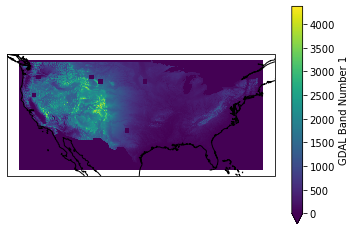

In [59]:
import matplotlib.pyplot as plt
ax = plt.axes(projection=ccrs.PlateCarree())
dr.plot.pcolormesh(ax=ax, vmin = 0)
ax.coastlines()

In [60]:
ds_out = xr.Dataset(
    {
        "lat": (["lat"], lat_lst),
        "lon": (["lon"], lon_lst),
    }
)
ds_out

<xarray.Dataset>
Dimensions:  (lat: 51, lon: 111)
Coordinates:
  * lat      (lat) float64 25.0 25.5 26.0 26.5 27.0 ... 48.0 48.5 49.0 49.5 50.0
  * lon      (lon) float64 -125.0 -124.5 -124.0 -123.5 ... -71.0 -70.5 -70.0
Data variables:
    *empty*

In [61]:
regridder = xe.Regridder(ds, ds_out, "bilinear")
dr_out = regridder(dr)
dr_out

<xarray.DataArray (lat: 51, lon: 111)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -125.0 -124.5 -124.0 -123.5 ... -71.0 -70.5 -70.0
  * lat      (lat) float64 25.0 25.5 26.0 26.5 27.0 ... 48.0 48.5 49.0 49.5 50.0
Attributes:
    regrid_method:  bilinear

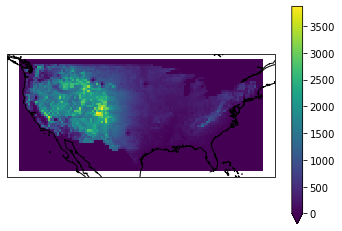

In [62]:
ax = plt.axes(projection=ccrs.PlateCarree())
dr_out.plot.pcolormesh(ax=ax, vmin = 0)
ax.coastlines()

In [63]:
dr_np = dr_out.to_numpy()
dr_np.shape

(51, 111)

In [65]:
dr_np[dr_np<0] = 0
# sum(dr_np.flatten() < 0)

0.0 3868.5789


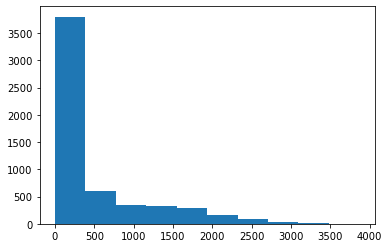

In [66]:
plt.hist(dr_np.flatten())
print(min(dr_np.flatten()), max(dr_np.flatten()))

In [67]:
np.save(
    r"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/03_Preprocess_Data/npy_Files/SRTM_US.npy", 
    dr_np
    )